# Import modules

In [1]:
import pickle
import numpy as np
import pandas as pd
from skimage import io
import os

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from time import time
from random import shuffle

import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.datasets import ImageFolder
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_style("dark")

# Define constants 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# !unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip -d /content/gdrive/MyDrive/simpsons
!unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip

In [5]:
os.listdir()

['.config',
 'characters_illustration.png',
 'testset',
 'gdrive',
 'train',
 'sample_submission.csv',
 'sample_data']

In [30]:
# Все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

# Работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Директории изображений
MAIN_DIR = Path()
# TRAIN_DIR = MAIN_DIR / "data/train/simpsons_dataset"
# TEST_DIR = MAIN_DIR / "data/testset"

TRAIN_DIR = MAIN_DIR / "train/simpsons_dataset"
TEST_DIR = MAIN_DIR / "testset/testset"
if not torch.cuda.is_available():
    print('❌CUDA is not available.  Training on CPU ...')
else:
    print('✔️CUDA is available!  Training on GPU ...')

✔️CUDA is available!  Training on GPU ...


In [7]:
CLASSES_NAMES = sorted(os.listdir(TRAIN_DIR))
CLASSES_IDXS = np.arange(0, len(CLASSES_NAMES))
N_CLASSES = len(CLASSES_IDXS)
print(N_CLASSES, CLASSES_NAMES)
print(CLASSES_IDXS)

42 ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


$out = \frac{in - \mu}{\sigma} $

# Visualise distributions and analize data

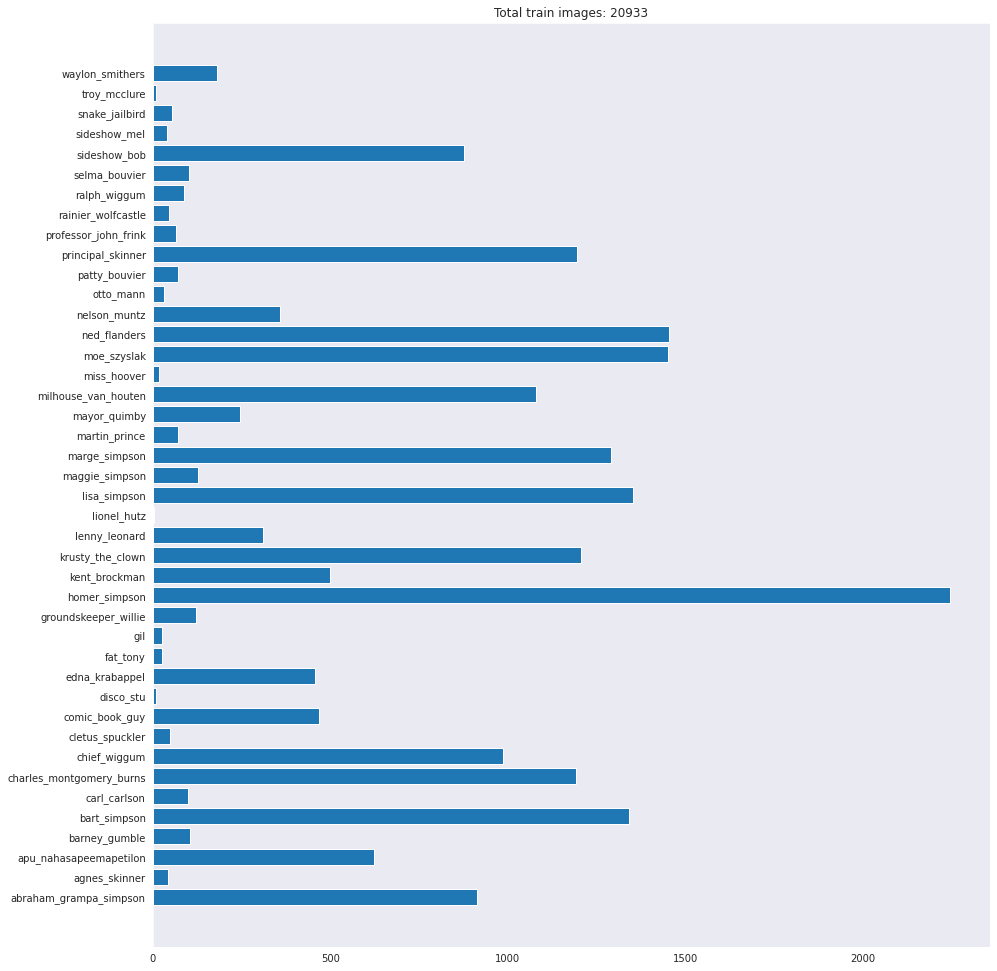

In [8]:
counter = []

for target in CLASSES_NAMES:
    imgs = os.listdir(TRAIN_DIR / target)
    counter.append(len(imgs))

TOTAL_IMAGES = sum(counter)
plt.figure(figsize=(15, 17))
plt.title(f"Total train images: {TOTAL_IMAGES}")
plt.barh(CLASSES_NAMES, counter)
plt.show()

## Calculate mean and std

In [9]:
def get_mean_and_std(batch_size):
    training_transforms = transforms.Compose([
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
        transforms.ToTensor()
        ])
    dataset = ImageFolder(root=TRAIN_DIR, transform=training_transforms)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in tqdm(loader):
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    mean /= total_images_count
    std /= total_images_count

    return mean, std


# mean, std = get_mean_and_std(512)
# mean, std
# (tensor([0.4623, 0.4075, 0.3524]), tensor([0.2125, 0.1913, 0.2212]))

# Create DataLoader

train -> val -> test

## Train, val dataloaders

In [92]:
class SimpsonsDataSet():
    def __init__(self, *, train_dir, valid_size=0.25, total_images=20933):
        self.train_dir = train_dir
        # self.test_dir = test_dir
        self.valid_size = valid_size
        self.total_images = total_images

        self.mean = torch.Tensor([0.485, 0.456, 0.406])
        self.std = torch.Tensor([0.229, 0.224, 0.225])

        self.train_transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            # transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
            ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
            ])

        self.train_dataset = ImageFolder(root=self.train_dir,
                                         transform=self.train_transform)
        # self.test_dataset = ImageFolder(root=self.test_dir,
        #                                  transform=self.test_transform)

    def get_train_val_loader(self, batch_size):

        valid_images = int(self.valid_size * self.total_images)

        total_indexes = list(range(self.total_images))
        shuffle(total_indexes)
        train_subset = Subset(self.train_dataset, total_indexes[valid_images:])
        valid_subset = Subset(self.train_dataset, total_indexes[0:valid_images])
        

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

        valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader

    def get_test_loader(self, batch_size):
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        return test_loader

    def show_train_images(self):
        loader = self.get_test_loader(9)
        for x, y in loader:
            grid = make_grid(x, nrow=3)
            print(f"labels: {y}")
            plt.figure(figsize=(11, 11))
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            break


## Test dataloader

In [49]:
class TestDataset(Dataset):
    def __init__(self, test_dir):
        super().__init__()
        self.test_dir = test_dir
        self.test_images = len(os.listdir(test_dir))
        self.transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        self.files = sorted(list(os.listdir(test_dir)))
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(TEST_DIR / self.files[index])
        image.load()
        return self.transform(image), self.files[index]

# Check DataLoader

In [11]:
BATCH_SIZE = 32

datasets = SimpsonsDataSet(train_dir=TRAIN_DIR, test_dir=TEST_DIR)
train_loader, val_loader = datasets.get_train_val_loader(BATCH_SIZE)
test_loader = datasets.get_test_loader(BATCH_SIZE)

5233


In [12]:
#1:18
# train_classes = {i: 0 for i in range(44)}
# for _, y in tqdm(train_loader):
#     for i in y.tolist():
#         train_classes[i] += 1
# plt.bar(list(train_classes.keys()), train_classes.values(), color='g')
# plt.show()

In [13]:
# val_classes = {i: 0 for i in range(44)}
# for _, y in tqdm(val_loader):
#     for i in y.tolist():
#         val_classes[i] += 1
# plt.bar(list(val_classes.keys()), val_classes.values(), color='g')
# plt.show()

bart_simpson 4


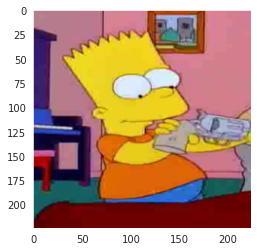

In [14]:
sns.set_style("dark")
iter_val_loader = iter(val_loader)
X, y = next(iter_val_loader)
target = y[0]
class_name = CLASSES_NAMES[target]
class_index = CLASSES_IDXS[target]
print(class_name, class_index)
data = np.transpose(X[0], (1, 2, 0)) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
plt.imshow(data)


homer_simpson 15


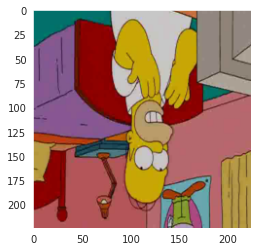

In [15]:
sns.set_style("dark")
iter_train_loader = iter(train_loader)
X, y = next(iter_train_loader)
target = y[0]
class_name = CLASSES_NAMES[target]
class_index = CLASSES_IDXS[target]
print(class_name, class_index)
data = np.transpose(X[0], (1, 2, 0)) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
plt.imshow(data)

# Create an architecture

In [96]:
class CNNClassifier(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128)
        )
        self.linear = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, n_classes)
        )
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = x.view(x.size(0), -1)
        logits = self.linear(x)
        return logits

In [97]:
class FitModel():
    def __init__(self, model, batch_size=32):
        self.model = model.to(DEVICE)

        self.datasets = SimpsonsDataSet(train_dir=TRAIN_DIR)
        self.train_loader, self.val_loader = self.datasets.get_train_val_loader(batch_size)
        
        self.total_images = 20933
        self.write_loss = 10
        
        # self.weight = _get_weight(self)

        self.criterion = nn.CrossEntropyLoss(weight=self._get_weight())
        self.optimizer = torch.optim.Adam(self.model.parameters())

        self.history = {"train_loss": [],
                        "valid_loss": [],
                        "train_acc": [], 
                        "valid_acc": [],}
    
    def _get_weight(self):
        counter = []

        for target in CLASSES_NAMES:
            imgs = os.listdir(TRAIN_DIR / target)
            counter.append(len(imgs))
        counter = torch.Tensor(counter)
        total_images = sum(counter)
        weights = counter / total_images
        return weights.to(DEVICE)

    def _train(self, current_epoch):
        loss_sum = 0.
        running_corrects = 0
        images_in_loader = 0
        
        loop = tqdm(enumerate(self.train_loader, start=1),
                    leave=True,
                    total=len(self.train_loader))

        self.model.train()
        for batch_number, (X, y) in loop:

            X = X.to(DEVICE)
            y = y.to(DEVICE)

            self.optimizer.zero_grad()

            output = self.model(X)
            loss = self.criterion(output, y)
            loss.backward()
            self.optimizer.step()
            
            preds = torch.argmax(output, 1)
            running_corrects += torch.sum(preds == y.data).item()
            loss_sum += loss.item()
            images_in_loader += len(X)

            if batch_number % self.write_loss == 0:
                self.history["train_loss"].append(loss_sum / self.write_loss)
                loss_sum = 0.

            loop.set_description(f"Train epoch: {current_epoch}")
            loop.set_postfix(loss=round(loss.item(), 2))
        self.history["train_loss"].append(loss_sum / (batch_number % self.write_loss))
        self.history["train_acc"].append(running_corrects / images_in_loader)

    
    def _valid(self, current_epoch):
        loss_sum = 0.
        images_in_loader = 0
        

        loop = tqdm(enumerate(self.val_loader, start=1),
                    leave=True,
                    total=len(self.val_loader))
        
        with torch.no_grad():
            self.model.eval()
            running_corrects = 0.0
            for batch_number, (X, y) in loop:
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                output = self.model(X)
                loss = self.criterion(output, y)

                loss_sum += loss.item()

                preds = torch.argmax(output, 1)
                running_corrects += torch.sum(preds == y.data).item()
                images_in_loader += len(X)
                
                if batch_number % self.write_loss == 0:
                    
                    self.history["valid_loss"].append(loss_sum / self.write_loss)
                    loss_sum = 0.

                loop.set_description(f"Valid epoch: {current_epoch}")
                loop.set_postfix(loss=round(loss.item(), 2))
            self.history["valid_loss"].append(loss_sum / (batch_number % self.write_loss))
            self.history["valid_acc"].append(running_corrects / images_in_loader)

    def fit(self, epochs=5):
        for epoch in range(1, epochs + 1):
            self._train(epoch)
            self._valid(epoch)
    
    def plot_losses(self):
        sns.set_style("darkgrid")
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        axes[0, 0].set_title("Train loss")
        axes[0, 0].plot(self.history["train_loss"])

        axes[0, 1].set_title("Valid loss")
        axes[0, 1].plot(self.history["valid_loss"])

        axes[1, 0].set_title("Train acc")
        axes[1, 0].plot(self.history["train_acc"])

        axes[1, 1].set_title("Valid acc")
        axes[1, 1].plot(self.history["valid_acc"])

    def submit_pred(self, batch_size):
        test_dataset = TestDataset(TEST_DIR)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            self.model.eval()
            logits = []
            image_names = []

            for X, batch_names in tqdm(test_loader):
                X = X.to(DEVICE)
                
                output = self.model(X).cpu()
                batch_logits = torch.argmax(output, 1)
                
                logits.append(batch_logits)
                image_names.append(np.array(batch_names))
            names = np.concatenate(image_names)
            probs = torch.cat(logits).numpy()
            labels = self._get_labels(probs)
            submission = pd.DataFrame({"Id": names, "Expected": labels})
            submission.to_csv("submissuin_.csv", index=False)

    def _get_labels(self, probs):
        labels = []
        for name in probs:
            labels.append(CLASSES_NAMES[name])
        return labels


BATCH_SIZE = 64


In [98]:
model = CNNClassifier(N_CLASSES)

In [99]:
cnn_model = FitModel(model, BATCH_SIZE)

In [ ]:
cnn_model.fit(epochs=13)

Train epoch: 4:  93%|█████████▎| 230/246 [01:30<00:06,  2.66it/s, loss=0.52]

In [ ]:
cnn_model.submit_pred(32)

In [ ]:
cnn_model.plot_losses()

In [67]:
a = ["a", "b", "c"]
b = [1, 2, 3]
pd.DataFrame({"file": a, "id": b})

,file,id
0,a,1
1,b,2
2,c,3


In [23]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

AttributeError: ignored

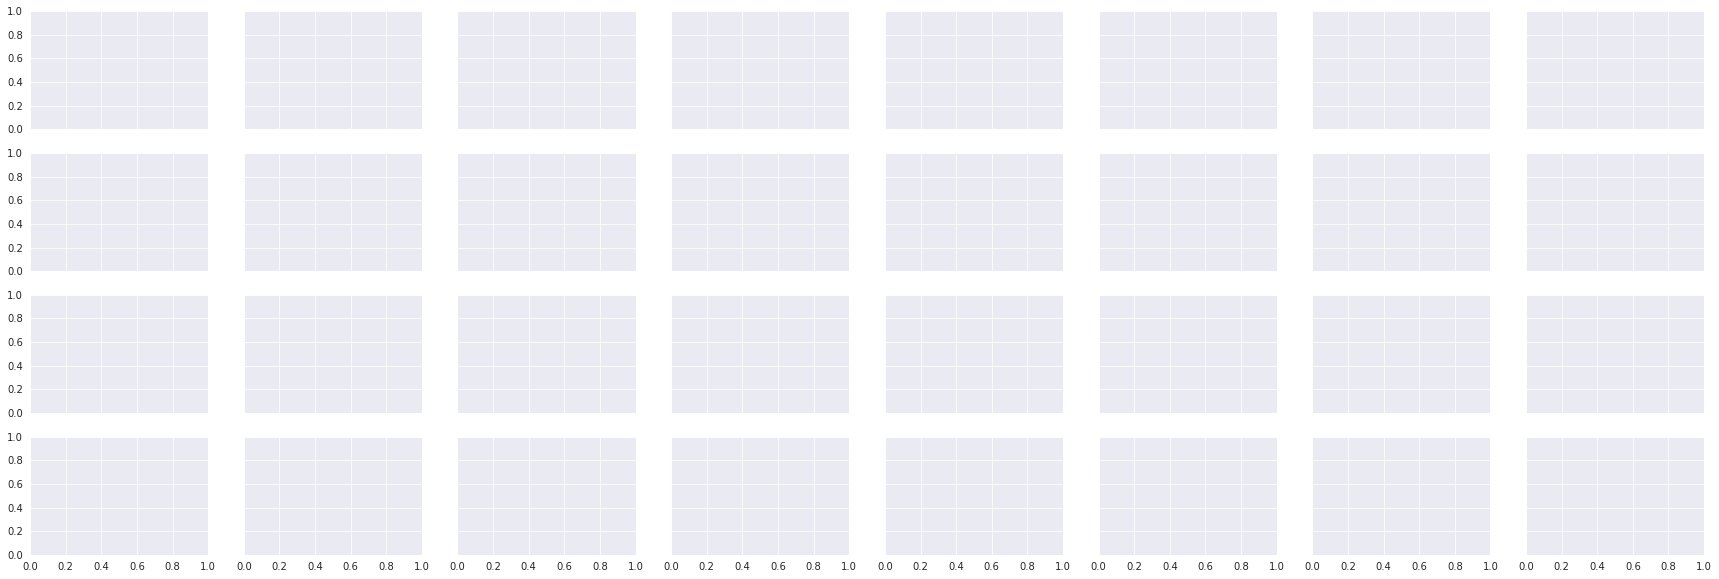

In [24]:
fig, axes = plt.subplots(4, 8, figsize=(30, 10), sharey=True, sharex=True)
cnn_model.model.eval()
with torch.no_grad():
    for X, y in cnn_model.test_loader:
        X = X.to(DEVICE)
        outputs = cnn_model.model(X).to("cpu")
        preds = torch.argmax(outputs, 1)
        for i, ax in enumerate(axes.flatten()):
            imshow(X[i].to("cpu"), title=CLASSES_NAMES[preds[i]], plt_ax=ax)
        break
